In [1]:
"""
動作概要
ユーチュラというサイトの情報を収集する
"""
import requests
import datetime
import time

dt_now  = datetime.datetime.now()

year = str(dt_now.year)
month = str(dt_now.month).zfill(2)#一桁付きは0を先頭につける
print(month)


#ユーチュラのランキング最後尾まで集める。日々増加するので適宜更新
end_page = 2000


#end_pageまでデータを集める
#ファイル名は4桁になるように指定して、各ページのソースコードを保存する
for i in range(1,end_page):
    time.sleep(1)
    if i != 1:
        get_url_info = requests.get('https://ytranking.net/ranking/?p={0}&mode=view&date={1}{2}'.format(i,year,month))
    else:
        get_url_info = requests.get('https://ytranking.net/ranking/?mode=view&date={0}{1}'.format(year,month))
    fname = str(i).zfill(4)
    with open('ytbrank_str/{}.txt'.format(fname),'wb')as file:
        for chunk in get_url_info.iter_content(4029):
            file.write(chunk)
          

12


In [2]:
"""
動作概要
チャンネル名を含む行のみ抜き取り、不要な情報を取り除く。チャンネル名のみの情報をcsvにまとめる
"""
import csv
import numpy as np
import pandas as pd
import glob
import os
import re
import datetime


dt_now  = datetime.datetime.now()
month = str(dt_now.month).zfill(2)#一桁付きは0を先頭につける
vn = []

#ソースコードを保存したディレクトリのパス名
path = "C:\\"#指定したディレクトリに保存
    
files = os.listdir(path)
#編集無しでnameファイルを作成する。
for filename in files:
    s = os.path.splitext(os.path.basename(filename))[0]
    #print("ファイルの名前は%s"%(s))
    with open("{0}{1}.txt".format(path,s),encoding="utf-8")as f:
        line = f.readlines()#行リスト
        for i in range(len(line)):
            if '<p><i class="material-icons" title="チャンネル登録者数"' in line[i]:
                vn.append(line[i-1])
        vn2 = [x.lstrip('\t<p class="title">') for x in vn]
        vn3 = [x.rstrip('</p>\t<aside>\n') for x in vn2]
        
df = pd.DataFrame(index=vn3)
df.to_csv('kakasi_csv_only_name_ytb_str_{}.csv'.format(month),encoding="utf_8_sig")
print("done")

done


In [3]:
"""
動作概要
チャンネル名をすべて小文字アルファベットに統一し、アルファベットの出現回数をカウントする
動作不良となるチャンネル名が存在するため、そういったチャンネルは例外処理で省く
"""
import pandas as pd
import datetime
from pykakasi import kakasi

dt_now  = datetime.datetime.now()
month = str(dt_now.month).zfill(2)#一桁付きは0を先頭につける

#日本語変換用
kakasi = kakasi()
kakasi.setMode('H', 'a')
kakasi.setMode('K', 'a')
kakasi.setMode('J', 'a')

conv = kakasi.getConverter()

df = pd.read_csv('kakasi_csv_only_name_ytb_str_{}.csv'.format(month),index_col=0)

#リスト作成
#nameリストを作成。name[i]で指定できる
name = df.index.values
print("name:{}".format(name))
length = []
alphabet = []

#アルファベットリスト作成用
for i in range(97, 123):
    alphabet.append(chr(i))

#bag-of-alphabet2次元リスト作成
boa = [[0]*len(alphabet) for l in range(len(name))]


for i in range(len(name)):#行
    try:
        v = conv.do(name[i]).lower()#小文字にそろえる
    except TypeError:
        print("{0}番目の{1}がうまくできませんでした".format(i,name[i]))
        pass
    v2 = v.replace(" ","")#空欄あったら削除
    v3 = v2.replace(".","")#空欄あったら削除
    length.append(len(v3))#文字の長さリストに各VTuberの長さを入れる
    chl = list(v3)#アルファベット分割
    for j in range(len(chl)):#列
        for k in range(len(alphabet)):#名前のアルファベット出現回数
            if chl[j] == alphabet[k]:#名前のアルファベットが存在した分だけ
                boa[i][k] += 1#アルファベット出現回数を1増加させる


df2 = pd.DataFrame(boa, index=name, columns=alphabet)
df2.insert(0,"Length",length)#文字数カウントを追加
df2
df2.to_csv('kakasi_vector_name_ytb_str_{}.csv'.format(month),encoding="utf_8_sig")

print("done")

name:["Fischer's-フィッシャーズ-" 'キッズライン♡Kids Lin' '東海オンエア' ... 'じーじー' '抹茶らて'
 'Save the children']
6868番目のnanがうまくできませんでした
13276番目のnanがうまくできませんでした
19563番目のnanがうまくできませんでした
29385番目のnanがうまくできませんでした
30213番目のnanがうまくできませんでした
30357番目のnanがうまくできませんでした
34580番目のnanがうまくできませんでした
done


In [4]:
"""
動作概要
作成したデータセットを使って機械学習を行い、5交差検証で正解率とF値を算出する
元のデータセットから上1万行、下１万行を抽出して学習させる
データセットの正規化処理とパラメータチューニングの組み合わせが、
生の出現頻度×チューニングなし
が最もスコアが高かったため、この組み合わせを継続して値を確認している
"""
#ライブラリのインポート
import xgboost as xgb
from sklearn import model_selection
#ハイパーパラメータ探索のため、ランダムサーチ
from sklearn.model_selection import RandomizedSearchCV
from scipy import stats
#評価関係
from sklearn import metrics
from sklearn.metrics import confusion_matrix, classification_report,make_scorer,accuracy_score,f1_score,matthews_corrcoef
#データ分割用
from sklearn.model_selection import train_test_split,StratifiedKFold,cross_validate
from sklearn.utils.fixes import loguniform
#データを扱うためのpandas
import pandas as pd
import scipy as sp
import numpy as np
#時間計測
import time
import pprint
import matplotlib.pyplot as plt
%matplotlib inline

In [18]:
#特徴ベクトルを整理
import datetime
dt_now  = datetime.datetime.now()
month = str(dt_now.month).zfill(2)#一桁付きは0を先頭につける

df = pd.read_csv("kakasi_vector_name_ytb_str_{}.csv".format(month),index_col=0)

#上下10000個だけ抽出
df_head=df[0:10000]
df_tail=df[-10001:-1]
df_marge=pd.concat([df_head,df_tail])
df_marge
df=df_marge

(array([1.8408e+04, 0.0000e+00, 1.3670e+03, 0.0000e+00, 0.0000e+00,
        1.9800e+02, 0.0000e+00, 2.1000e+01, 0.0000e+00, 6.0000e+00]),
 array([0. , 0.4, 0.8, 1.2, 1.6, 2. , 2.4, 2.8, 3.2, 3.6, 4. ]),
 <a list of 10 Patch objects>)

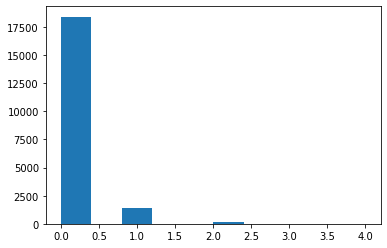

In [22]:
#ラベル付け。半分で分けて0,1でつける
a = len(df)#行の長さを取得
if(a % 2 == 0):
    label = [0]* int(a/2) + [1] * int(a/2)
else:
    label = [0]* int(a/2 + 1) + [1] * int(a/2)

#X1 = df.drop("Length",axis=1)
y = label

X1

#正規化なし
#X=X1
#ベクトル正規化
X = X1.apply(lambda x:x/np.sqrt(sum(x**2)), axis=1)

#0-1正規化
#X= ((X1.T - X1.T.min()) / (X1.T.max() - X1.T.min())).T


X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=0)

X1.describe()
plt.hist(X1["w"])
#X.to_csv("kakasi_ex_11.csv",encoding="utf-8")

In [23]:
#5交差検証
start = time.time()

y_true = []


#学習
clf = xgb.XGBClassifier()
clf.fit(X,y)

kf = StratifiedKFold(n_splits=5,shuffle=True,random_state=0)

scoring={
    "accuracy":make_scorer(accuracy_score),
    "f1_score":make_scorer(f1_score)
}    
    
scores_kf = cross_validate(clf,X,y,cv=kf,n_jobs=1,scoring = scoring)

print("5交差検証の結果")
pprint.pprint(scores_kf)
    
    
elapsed_time = time.time() - start
print(f'Time : {elapsed_time}')

5交差検証の結果
{'fit_time': array([1.71338916, 1.71382046, 1.69342732, 1.73043537, 1.76197362]),
 'score_time': array([0.01562095, 0.01562572, 0.01558304, 0.02103734, 0.01566148]),
 'test_accuracy': array([0.5425 , 0.5405 , 0.5455 , 0.53725, 0.53975]),
 'test_f1_score': array([0.58522212, 0.58622242, 0.58681818, 0.58692256, 0.5725563 ])}
Time : 10.823177576065063
